In [1]:
#Automated reloading of custom modules
%load_ext autoreload
%autoreload 2

#Standard modules
import os
import time
import random

import numpy as np
import scipy

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from datetime import datetime

#Custom modules
import helpers as hlp
import models as mdl

!nvidia-smi

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### GPU and Reproductability

In [3]:
# Check avaibale device
DEVICE = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(DEVICE))
torch.cuda.empty_cache()

# Reproductilility
SEED = 0
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

Device: cuda:7
Thu May  5 17:57:58 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.03   Driver Version: 450.119.03   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  On   | 00000000:04:00.0 Off |                  N/A |
|  0%   45C    P2    56W / 250W |   4368MiB / 11178MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  On   | 00000000:05:00.0 Off |                 

### Parameters

In [4]:
#Dataset
DATASET = "FMNIST" 
MODEL = "ResNet9"
REDUCED = 0.2
FEATURE_DIM = 128

#Collaborative learning
N_CLIENTS = 2
SIZES = None # None for uniform sizes or array of length N_CLIENTS using all the data
ALPHA = "uniform" #'uniform', 'disjoint' or postive.

#Learning
BATCH_SIZE = 64
ROUNDS = 100
EPOCHS_PER_ROUND = 1
LR=1e-3
LAMBDA = 1
CRITERION = nn.CrossEntropyLoss()
CRITERION_DISC = nn.BCELoss()
N_EVAL = 1 #Evaluate train and test performace after N_EVAL epochs

#Directories
DATE = datetime.now()
EXPORT_DIR = "./saves/Experiments/" + DATE.strftime("%d-%m-%Y/%H-%M-%S")
#os.makedirs(EXPORT_DIR, exist_ok=True)

### Data loading

** Using FMNIST **
Load train data...
Load validation data...
Dataset sizes:
	- Train: (12000, 1, 28, 28) (37.728 MB)
	- Validation (2000, 1, 28, 28) (6.288 MB)


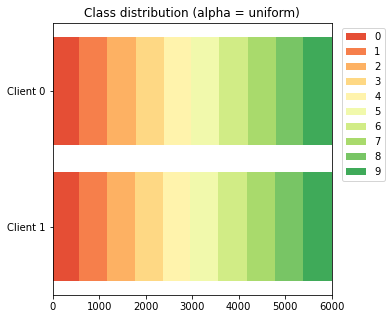

In [5]:
# Load dataset
train_input, train_target, val_input, val_target, meta = hlp.load_data(dataset=DATASET, reduced=REDUCED, device=DEVICE)

#Create custom torch datasets
train_ds = hlp.CustomDataset(train_input, train_target)
val_ds = hlp.CustomDataset(val_input, val_target)

#Split dataset
train_ds_list, val_ds_list = hlp.split_dataset(N_CLIENTS, train_ds, val_ds, ALPHA, SIZES)

#Create dataloader
train_dl_list = hlp.ds_to_dl(train_ds_list, batch_size=BATCH_SIZE)
val_dl_list = hlp.ds_to_dl(val_ds_list)
global_val_dl = hlp.ds_to_dl(val_ds)

#Visualize partition
hlp.visualize_class_dist(train_ds_list, meta["n_class"], title="Class distribution (alpha = {})".format(ALPHA),savepath=None)

## Traditional (spearated) learning

Round 100 done. (4.4s)          

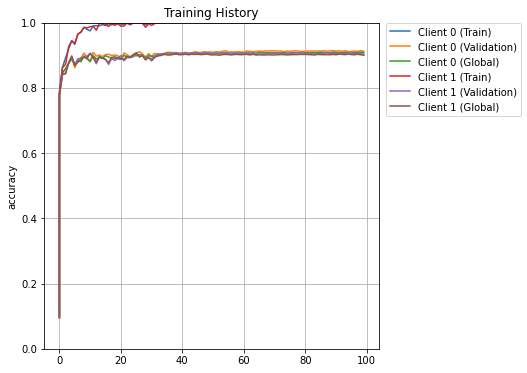

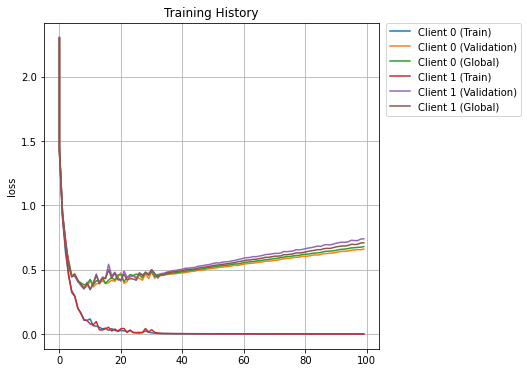

In [6]:
# Model initialization
client_models = [mdl.get_model(MODEL, FEATURE_DIM, meta).to(DEVICE) for _ in range(N_CLIENTS)]

# Performance tracker
perf_trackers = [hlp.PerfTracker(client_models[i], 
                                 {"Train": train_dl_list[i], "Validation": val_dl_list[i], "Global": global_val_dl}, 
                                 CRITERION, meta["n_class"], ID="Client {}".format(i)) for i in range(N_CLIENTS)]

# Optimizers
optimizers = [torch.optim.Adam(m.parameters(), lr=LR) for m in client_models]

# Feature tracker
feat_tracker = hlp.FeatureTracker(client_models, train_ds_list, FEATURE_DIM, meta)

#Each client updates its model independently on its own dataset
for r in range(ROUNDS):
    t0 = time.time()
    
    for client_id in range(N_CLIENTS):
        #Setting up the local training
        model = client_models[client_id]
        model.train()
        optimizer = optimizers[client_id]

        #Local update
        for e in range(EPOCHS_PER_ROUND):
            for inputs, target in train_dl_list[client_id]:
                optimizer.zero_grad()
                logits = model(inputs)
                loss = CRITERION(logits, target)
                loss.backward()
                optimizer.step()
        
        #Tracking performance
        if r % N_EVAL == 0:
            perf_trackers[client_id].new_eval(index=r)      
        
    # Compute representations
    feat_tracker.new_round()
    
    t1 = time.time()    
    print("\rRound {} done. ({:.1f}s)".format(r+1, t1-t0), end=10*" ")   

# Plot training history
hlp.plot_global_training_history(perf_trackers, metric="accuracy")
hlp.plot_global_training_history(perf_trackers, metric="loss")

### Learning with private KD

Round 100 done. (4.8s)          

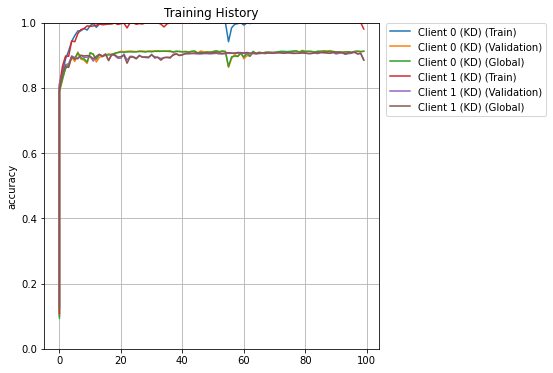

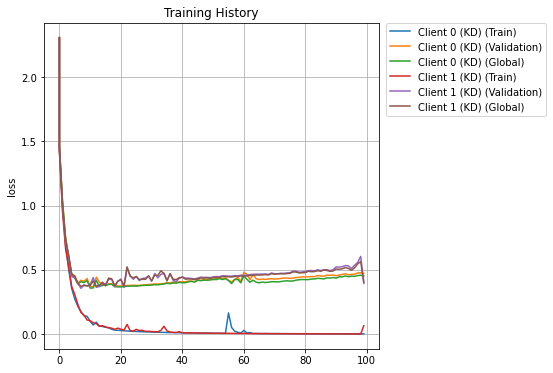

In [7]:
# Model initialization
client_models_kd = [mdl.get_model(MODEL, FEATURE_DIM, meta).to(DEVICE) for _ in range(N_CLIENTS)]

# Performance tracker
perf_trackers_kd = [hlp.PerfTracker(client_models_kd[i], {"Train": train_dl_list[i], "Validation": val_dl_list[i], "Global": global_val_dl}, 
                                    CRITERION, meta["n_class"], ID="Client {} (KD)".format(i)) for i in range(N_CLIENTS)]

# Optimizers
optimizers_kd = [torch.optim.Adam(m.parameters(), lr=LR) for m in client_models_kd]

# Feature tracker and discriminator
feat_tracker_kd = hlp.FeatureTracker(client_models_kd, train_ds_list, FEATURE_DIM, meta)
discriminators = [mdl.Discriminator(method="cosine_similarity") for _ in range(N_CLIENTS)]

#Each client updates its model locally on its own dataset (Standard)
for r in range(ROUNDS):
    t0 = time.time()
    
    for client_id in range(N_CLIENTS):
        #Setting up the local training
        disc = discriminators[client_id]
        model = client_models_kd[client_id]
        model.train()
        optimizer = optimizers_kd[client_id]

        #Local update
        for e in range(EPOCHS_PER_ROUND):
            for inputs, targets in train_dl_list[client_id]:
                # Reset gradient
                optimizer.zero_grad()
                
                # Local representation
                features = model.features(inputs)
                logits = model.classifier(features)
                
                # Compute estimated probabilities
                features_global = feat_tracker_kd.get_global_features().to(DEVICE)
                targets_global = torch.arange(meta["n_class"]).to(DEVICE)
                scores, disc_targets = disc(features, features_global, targets, targets_global)
                
                # Optimization step
                if LAMBDA:
                    loss = CRITERION(logits, targets) + LAMBDA*CRITERION_DISC(scores, disc_targets)
                else:
                    loss = CRITERION(logits, targets)
                loss.backward()
                optimizer.step()
        
        #Tracking performance
        if r % N_EVAL == 0:
            perf_trackers_kd[client_id].new_eval(index=r)      
        
    # Compute representations
    feat_tracker_kd.new_round()
    
    t1 = time.time()    
    print("\rRound {} done. ({:.1f}s)".format(r+1, t1-t0), end=10*" ")  

# Plot training history
hlp.plot_global_training_history(perf_trackers_kd, metric="accuracy")
hlp.plot_global_training_history(perf_trackers_kd, metric="loss")

### Convert to executable

In [7]:
# Convert to executable (without the Magic cells)
#!jupyter nbconvert \
#    --TagRemovePreprocessor.enabled=True \
#    --TagRemovePreprocessor.remove_cell_tags 'Magic' \
#    --TemplateExporter.exclude_markdown=True \
#    --to python "BlindLearning.ipynb"

In [16]:
from sklearn.manifold import TSNE
user = 0
embedder =  TSNE(n_components=2, learning_rate='auto', init='random', perplexity=30)
feat_emb = embedder.fit_transform(torch.cat((features_history[-1][user], features_global[-1])).numpy())

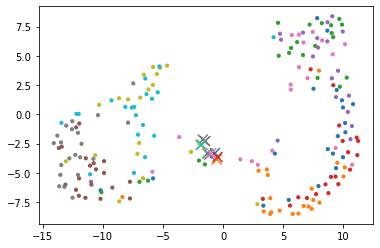

In [17]:
plt.scatter(feat_emb[:-10,0], feat_emb[:-10,1], c=train_ds_list[user].targets, s=10, cmap="tab10")
plt.scatter(feat_emb[-10:,0], feat_emb[-10:,1], marker="x", c=range(10), s=100, cmap="tab10")

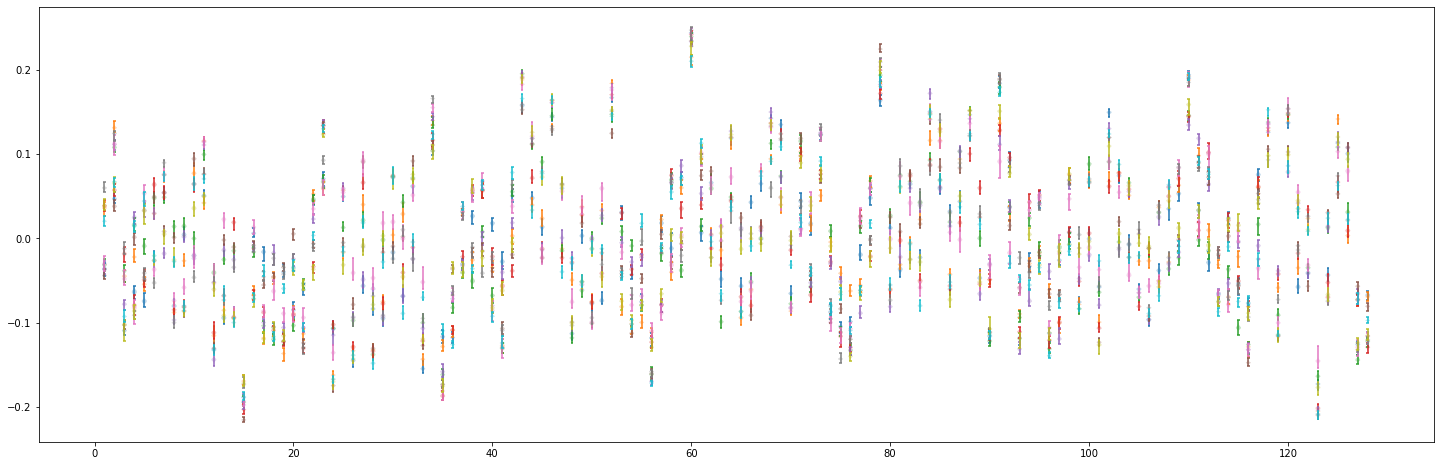

In [24]:
user = 0
r = -1
fig, ax = plt.subplots(1,1, figsize=(25,8))
with torch.no_grad():
    buffer = feat_tracker_kd.buffers[user][r]
    for c in range(10):
        plt.violinplot(buffer[train_ds_list[user].targets == c].transpose(0,1))

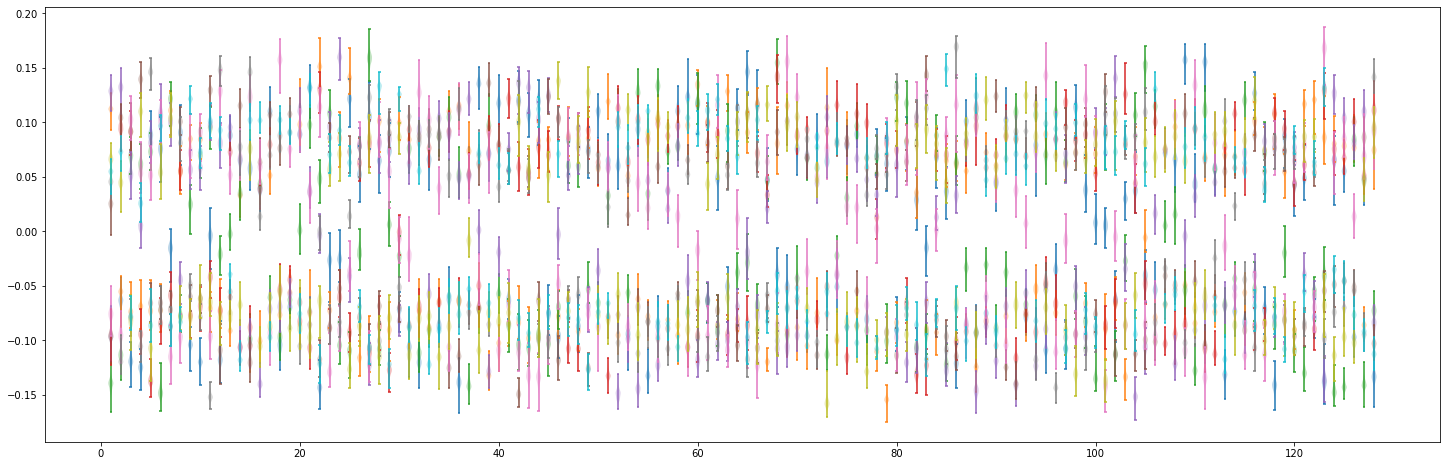

In [25]:
user = 0
r = -1
fig, ax = plt.subplots(1,1, figsize=(25,8))
with torch.no_grad():
    buffer = feat_tracker.buffers[user][r]
    for c in range(10):
        plt.violinplot(buffer[train_ds_list[user].targets == c].transpose(0,1))

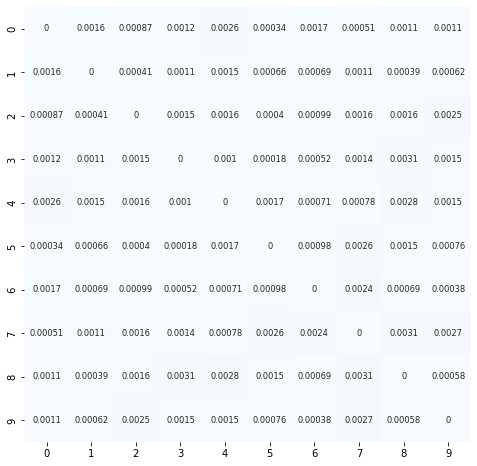

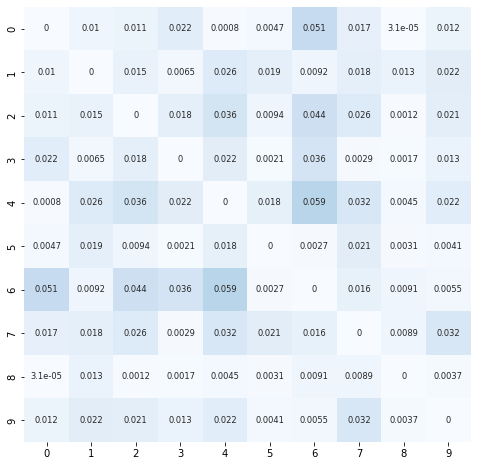

In [28]:
feat_tracker.plot_variance_heatmap()
feat_tracker_kd.plot_variance_heatmap()

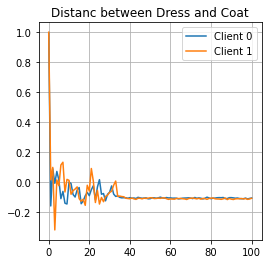

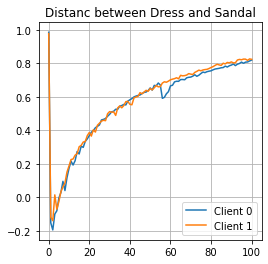

In [33]:
feat_tracker.plot_class_distance(3,4)
feat_tracker_kd.plot_class_distance(3,5)